In [1]:
import pandas as pd
import sqlite3
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.utils import save_image
from torch.distributions.normal import Normal

from PIL import Image

import math
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
import datetime
from skimage.util import img_as_ubyte
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import argparse

from datetime import datetime

from models.indiv_crossAttention_seq2seq import crossAttention

In [2]:
from IPython import display

In [3]:
# Log
from torch.utils.tensorboard import SummaryWriter

In [4]:
stochastic_mode         = 1#output  

# Make folder for outputs and logs


In [5]:
#Dataset name
dataset_name = "eth" # dataset options: 'university', 'zara_01', 'zara_02', 'eth', 'hotel'

In [6]:
__file__=os.getcwd()
print(__file__)

/notebook_data/trajectory_bitransformer_-main/trajectory_bitransformer_-main


In [7]:
now = datetime.now() # current date and time
current_time_date = now.strftime("%d_%m_%y_%H_%M_%S")
run_folder  = "Outputs/traj_pred_"+ dataset_name + "_" + str(os.path.basename(__file__)) + str(current_time_date)
os.makedirs(run_folder)

Skip to left side bar
>
/
Name
Last Modified

# Make log folder for tensorboard

In [8]:

SummaryWriter_path = "/notebook_data/work_dirs/dec_trans_test_no_decoder_1/"
#os.makedirs(SummaryWriter_path)   
writer = SummaryWriter(SummaryWriter_path,comment="ADE_FDE_Train")

# Make image folder to save outputs


In [9]:
image_path  = run_folder + "/Visual_Prediction"
os.makedirs(image_path)

# GPU


In [10]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cuda:0')

In [11]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.cuda.device_count()
torch.cuda.current_device()

0

# Variables


In [38]:
#DataBase Variables

image_folder_path       = 'data/data_trajpred/'+dataset_name
DB_PATH_train     = "./data/data_trajpred/"+dataset_name+"/pos_data_train.db"
cnx_train         = sqlite3.connect(DB_PATH_train)
DB_PATH_val     = "./data/data_trajpred/"+dataset_name+"/pos_data_val.db"
cnx_val         = sqlite3.connect(DB_PATH_val)
DB_DIR      = run_folder + '/database'
os.makedirs( DB_DIR )
DB_PATH2    = DB_DIR+'/db_one_ped_delta_coordinates_results.db'
cnx2        = sqlite3.connect(DB_PATH2)

#Other variables
T_obs                   = 8
T_pred                  = 12
T_total                 = T_obs + T_pred #8+12=20
data_id                 = 0 
batch_size              = 32
chunk_size              = batch_size * T_total # Chunksize should be multiple of T_total
in_size                 = 2
stochastic_out_size     = in_size * 2
hidden_size             = 256 #!64
embed_size              = 64 #16 #!64
global dropout_val
dropout_val             = 0.2 #0.5
teacher_forcing_ratio   = 0.7 # 0.9
regularization_factor   = 0.5 # 0.001
avg_n_path_eval         = 20
bst_n_path_eval         = 20
path_mode               = "top5" #"avg","bst","single","top5"
regularization_mode     = "regular" #"weighted","e_weighted", "regular"
startpoint_mode         = "on" #"on","off"
enc_out                 = "on" #"on","off"
biased_loss_mode        = 0 # 0 , 1


table_out   = "results_delta"
table       = "dataset_T_length_20delta_coordinates" #"dataset_T_length_"+str(T_total)+"delta_coordinates"
df_id       = pd.read_sql_query("SELECT data_id FROM "+table, cnx_train) #juste la colonne data_id de database
#print("dfshape",df_id.shape) #[4920 rows x 1 columns]
data_size   = df_id.data_id.max() * T_total
epoch_num   = 400
from_epoch  = 0

#Visual Variables
image_size              = 256  
image_dimension         = 3
mask_size               = 16
visual_features_size    = 128 
visual_embed_size       = 64  #128 #256 #64
vsn_module_out_size    = 256
to_pil = torchvision.transforms.ToPILImage()

FileExistsError: [Errno 17] File exists: 'Outputs/traj_pred_eth_trajectory_bitransformer_-main13_03_23_09_43_13/database'

# Model Path


In [13]:
model_path = run_folder + "/NNmodel" 
os.makedirs(model_path)   
model_path = model_path + str("/model")

# Homography Matrix

In [14]:
"""""
# la matrice fournie par eux
if dataset_name == 'eth' or dataset_name =='hotel':   # ETH dataset
    h = np.array([[0.0110482,0.000669589,-3.32953],[-0.0015966,0.0116324,-5.39514],[0.000111907,0.0000136174,0.542766]])
else:                                       # UCY dataset
    h = np.array([[47.51,0,476],[0,41.9,117],[0,0,1]])
"""""
# Matrice Standard
if dataset_name == 'eth':  
    h = np.array([[2.8128700e-02, 2.0091900e-03, -4.6693600e+00],[8.0625700e-04, 2.5195500e-02, -5.0608800e+00],[ 3.4555400e-04, 9.2512200e-05, 4.6255300e-01]]) #h pour eth
if dataset_name =='hotel':        
    h = np.array([[1.1048200e-02, 6.6958900e-04, -3.3295300e+00],[-1.5966000e-03, 1.1632400e-02, -5.3951400e+00],[1.1190700e-04, 1.3617400e-05, 5.4276600e-01]]) #h pour hotel
if dataset_name =='zara01': 
    h = np.array([[0.02174104, 0, -0.15],[0, -0.02461883, 13.77429807],[0, 0, 1]]) #h pour zara1
if dataset_name =='zara02': 
    h = np.array([[0.02174104, 0, -0.4],[0, -0.02386598, 14.98401686],[0, 0, 1]]) #h pour zara2
if dataset_name =='univ':
    h = np.array([[0.02220407, 0, -0.48],[0, -0.02477289, 13.92551292],[0, 0, 1]]) #h pour univ

# Handle Sequential Data

In [15]:
class TrajectoryPredictionDataset(torch.utils.data.Dataset): 
#Enc.cinématique reçoit la trajectoire observée de humain cible (input) de la forme T=(u1,u2-u1,u3-u2,..) qui consiste en les coordonnées de la position de départ et en les déplacements relatifs de l'humain entre les images consécutives.
#Ce format a été choisi car il permet au modèle de mieux capturer les similarités entre des trajectoires presque identiques qui peuvent avoir des points de départ différents. 
    def __init__(self, ROOT_DIR, DB_PATH, cnx):
        
        self.pos_df    = pd.read_sql_query("SELECT * FROM "+str(table), cnx)
        self.root_dir  = ROOT_DIR+'/visual_data'
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize((image_size,image_size)), \
                                                         torchvision.transforms.ToTensor(), \
                                                         torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
        self.visual_data = []
        # read sorted frames
        for img in sorted(os.listdir(self.root_dir)): 
            self.visual_data.append(self.transform( Image.open(os.path.join(self.root_dir)+"/"+img) ))
        self.visual_data = torch.stack(self.visual_data)  
        #print("visual_data:", self.visual_data) #tensor
        #print("shapevisual_data:", self.visual_data.shape) #torch.Size([1298, 3, 256, 256]) : 1298 blocs dans chaque bloc 3 sous blocs, et dans chaque sous bloc: 256 lignes et 256 colonnes

    def __len__(self):
        return self.pos_df.data_id.max() #data_id maximum dans dataset
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() 
        #print("idx :", idx)
        
        extracted_df     = self.pos_df[ self.pos_df["data_id"] == idx ] #table dont data_id=idx

        tensor           = torch.tensor(extracted_df[['pos_x_delta','pos_y_delta']].values).reshape(-1,T_total,in_size) #juste pos_x_delta et pos_y_delta de extracted_df (tensor)
        #print("tensor: ", tensor)
        obs, pred        = torch.split(tensor,[T_obs,T_pred],dim=1) #obs de 8 et pred de 12 à partir de tensor construit
        #print("obs: ", obs)
        #print("pred: ", pred)

        start_frames     = (extracted_df.groupby('data_id').frame_num.min().values/10).astype('int') #extracted_df dont data_id=idx, on prend minimum frame_num et aprés on divise par 10, cela represente start_frame
        extracted_frames = []
        for i in start_frames:            
            extracted_frames.append(self.visual_data[i:i+T_obs])
        frames = torch.stack(extracted_frames) #stack concatenates a sequence of tensors along a new dimension.
        start_frames = torch.tensor(start_frames) #tensor([start_frames])
        return obs, pred, frames, start_frames

# Initialize random weights for NN models


In [16]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.2, 0.2)

# Regularizer loss

The distance_from_line_regularizer function is implemented as a regularization method to enforce the predicted trajectory to stay close to the observed trajectory. The method is used to minimize the Euclidean distances between each step of the predicted trajectory and a line fitted to the observed trajectory.

It takes 2 inputs:
1-input_tensor : The observed trajectory in the form of a tensor of size (batch_size, T_obs, 2)
2-prediction : The predicted trajectory in the form of a tensor of size (batch_size, T_pred, 2)

The function first converts the input tensors to double precision, then it calculates the cumulative sum of the observed trajectory along the time axis. Next, it fits a line to the observed trajectory by calculating the slope and intercept of the line using the least square method. Then it calculates the real values of the predicted trajectory by adding the last point of the observed trajectory to the delta values predicted by the model. Next, it calculates the distance between each predicted point and the fitted line using the formula distance = |(theta0*x0+theta1) - y0| / sqrt(theta0^2 + 1) where x0, y0 are the coordinates of the predicted point, theta0, theta1 are the slope and intercept of the line respectively.

Finally, it applies a weighting scheme to the distances based on the regularization_mode:
weighted : The weights are linearly decreasing from T_pred to 1
e_weighted : The weights are exponentially decreasing from T_pred to 1
None : No weighting

It then calculates the mean distance over all the predicted points and returns it as sum_sigma_distance.

In [17]:
sum_sigma_distance  = torch.zeros(1) #tensor[(0.)]

def distance_from_line_regularizer(input_tensor,prediction):
    global sum_sigma_distance
    #the regularization is defined as the sum of Euclidean distances between each step of the predicted trajectory Tf , and a line fitted to the observed trajectory To.
    # Fit a line to observation points over batch 
    input_tensor    = input_tensor.double()
    prediction      = prediction.double()
    input_tensor    = input_tensor.cumsum(dim=1).double()
    X               = torch.ones_like(input_tensor).double().to('cuda', non_blocking=True)
    X[:,:,0]        = input_tensor[:,:,0]
    Y               = (input_tensor[:,:,1]).unsqueeze(-1).double()
    try:
        try:
            XTX_1           = torch.matmul( X.transpose(-1,-2), X).double().inverse()
        except:
            XTX_1           = torch.matmul( X.transpose(-1,-2), X).double().pinverse()
        XTY             = torch.matmul( X.transpose(-1,-2), Y)
        theta           = torch.matmul( XTX_1.double(), XTY.double())
        # Calculate real values of prediction instead of delta
        prediction[:,:,0] = prediction[:,:,0] + input_tensor[:,-1,0].unsqueeze(-1) 
        prediction[:,:,1] = prediction[:,:,1] + input_tensor[:,-1,1].unsqueeze(-1)
        
        # Calculate distance ( predicted_points , observation_fitted_line ) over batch
        theta0x0        = theta[:,0,:].double() * prediction[:,:,0].double()
        denominator     = torch.sqrt( theta[:,0,:].double() * theta[:,0,:].double() + 1 )
        nominator       = theta0x0 + theta[:,1,:] - prediction[:,:,1].double()
        distance        = nominator.abs() / denominator
        if regularization_mode =='weighted':
            weight              = torch.flip( torch.arange(1,T_pred+1).cuda().float(),[0])
            weight              = (weight / T_pred).repeat(distance.size(0)).view(-1,T_pred)
            weighted_distance   = weight * distance

        elif regularization_mode =='e_weighted':
            weight              = torch.flip( torch.arange(1,T_pred+1).cuda().float(),[0])
            weight              = (weight / T_pred).repeat(distance.size(0)).view(distance.size(0),T_pred)
            weight              = torch.exp(weight)
            weighted_distance   = weight*distance

        else:
            weighted_distance = distance
        sigma_distance  = torch.mean(weighted_distance,1)
        sum_sigma_distance  = torch.mean(sigma_distance)
        return sum_sigma_distance
    except:
        print("SINGULAR VALUE")
        sum_sigma_distance = torch.zeros(1).to('cuda', non_blocking=True) + 20
        return sum_sigma_distance

# Vision Transformer (partie vision)

### Spatial Features Extraction (Resnet 18)

In [18]:
from torch.utils.data import DataLoader 
from torchvision import datasets 
from torchvision.transforms import ToTensor 
from torchsummary import summary

Resnet function creates a ResNet model with the option to use a pretrained model from ImageNet, and to select the number of layers to unfreeze and delete.
The function also allows to define the number of input channels for the images (1, 2 or 3). It returns the ResNet model.

The function takes 4 parameters as input:
1-pretrain: a boolean value that determines whether to use a pretrained model from ImageNet or not. The default value is True, which means the model will be pretrained.
2-layers_to_unfreeze: an integer value that defines the number of layers at the end of the ResNet model that will be unfrozen for training. The default value is 8.
3-layers_to_delete: an integer value that defines the number of layers at the end of the ResNet model that will be deleted from the model. The default value is 2.
4-in_planes: an integer value that defines the number of input channels for the images. The supported values are 1, 2, or 3. The default value is 3.

The function starts by initializing the ResNet model with the specified pretrained setting, then creates a new nn.Sequential model to store the modified layers. It calculates the total number of layers in the ResNet model, and if this number is less than the number of layers to unfreeze, it sets the number of layers to unfreeze to the total number of layers. The function then loops through the children layers of the ResNet model and for the first layer it modifies the number of input channels to match the specified number of input channels, in case the input channel is 1 or 2, it modify the weight of the conv layer accordingly. Then the function applies freezing on some layers depending on the layers_to_freeze and layers_to_delete parameters. It appends the child layers to the new model if it's in the range of number_of_layers. Finally, it returns the new model.

This script defines a features_extraction class that inherits from the PyTorch nn.Module class. The class is used to extract features from an input image using a convolutional model (in this case, ResNet) and a pooling operation.
The class takes the convolutional model and the number of input channels for the images as input. The class overrides the forward method to reshape the input image, pass it through the convolutional model, and then apply the pooling operation. The resulting feature map is then returned.

The class takes 2 arguments in the constructor:
1-conv_model: the convolutional model that will be used for feature extraction. Currently, only ResNet is supported.
2-in_planes: the number of input channels for the images.
The class also creates an AdaptiveAvgPool2d object with the shape (1,1) to be used for the pooling operation.

The class overrides the forward method, which takes an input image, reshape the image to have the number of channels as defined by the in_planes parameter, pass it through the convolutional model, and then apply the pooling operation. The resulting feature map is then returned.

In [19]:
def Resnet(pretrain=True,layers_to_unfreeze=8,layers_to_delete=2,in_planes=3):
    """
    param:
        pretrain: Define if we load a pretrained model from ImageNet
        layers_to_unfreeze: Define the number of layers that we want to train at the end of the Resnet
        layers_to_delete: Define the numbers of layers that we want to delete
        in_planes: Define the numbers of input channels of images (supported values: 1,2 or 3)
    return: The Resnet model
    """
    resnet = torchvision.models.resnet18(pretrained=pretrain)
    # Create a new model cause we don't want the pooling operation at the end and the classifier
    model = nn.Sequential()
    number_of_layers = len(list(resnet.children())) - layers_to_delete # In practice it remove the pooling operation and the classifier

    if number_of_layers<layers_to_unfreeze:
        layers_to_unfreeze = number_of_layers
    layers_to_freeze = number_of_layers - layers_to_unfreeze
    i=0
    for child in resnet.children():
        # For the first layers we create a new weight if in_planes is not 3 cause ResNet is pretrain on image with 3 channels there is no version for 1 channel
        if i==0 and in_planes<3:
            if i<layers_to_freeze: # Define if we freeze this layer or no
                for param in child.parameters():
                    param.requires_grad = False # Freeze the layers by passing requires_grad attribute to False
            w = child._parameters['weight'].data # Get the weight for 3 channels data
            child._modules['0'] = nn.Conv2d(in_planes, 64, kernel_size=3, padding=1) # Define the new conv layer
            if in_planes == 1:
                child._parameters['weight'].data = w.mean(dim=1, keepdim=True) # If the number of channels is 1 we made the mean of channels to set the new weight
            else:
                child._parameters['weight'].data = w[:, :-1] * 1.5

        if i<layers_to_freeze: # Define if we freeze this layer or no
            for param in child.parameters():
                param.requires_grad = False # Freeze the layers by passing requires_grad attribute to False
        if i<number_of_layers: # To define if we keep this layer or not
            model.append(child) 
        i+=1
    return model


class features_extraction(nn.Module):
    """
    param:
    conv_model: The convolution model used before capsules for the moment only ResNet is supported
    in_planes: Numbers of channels for the image
    """
    def __init__(self,conv_model,in_planes: int):
        super().__init__()
        self.conv_model = conv_model
        self.in_planes = in_planes
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self,input):
        shape = input.size()
        x = input.view(-1,self.in_planes,shape[-2],shape[-1])
        x = self.conv_model(x)
        x = self.pooling(x)
        return x

### Transformer

The position_embedding function takes 2 arguments as input:
1-input: a tensor representing the input of the function, it's a 1-D tensor with the shape of (batch_size,)
2-d_model: an integer value representing the depth of the model, it's used to define the size of the output tensor.
The function starts by reshaping the input tensor to have a shape of (-1, 1) and creating a 1-D tensor called dim of shape (d_model/2,). Then it creates two tensors, sin and cos, by applying sin and cos functions on the input tensor element-wise with a scaling factor of 2 * dim / d_model. The function then creates an output tensor of shape (batch_size, d_model) and assigns the values of sin and cos tensors to the even and odd indices respectively. Finally, it returns the output tensor.

The sinusoid_encoding_table function takes 2 arguments as input:
1-max_len: an integer value representing the maximum length of the input tensor that the function will be applied on.
2-d_model: an integer value representing the depth of the model, it's used to define the size of the output tensor.
The function starts by creating a 1-D tensor called pos of shape (max_len) with integer values ranging from 0 to max_len-1, then it applies the position_embedding function on the pos tensor with the d_model value passed to the function as an argument. Finally, it returns the output of the position_embedding function.

These functions are used in the Transformer model to add position information to the input embeddings. The sinusoid_encoding_table function is used to create a lookup table of position embeddings, which is then used to add position information to the input embeddings in the forward pass.

In [20]:
def position_embedding(input, d_model):
    input = input.view(-1, 1)
    dim = torch.arange(d_model // 2, dtype=torch.float32, device=input.device).view(1, -1)
    sin = torch.sin(input / 10000 ** (2 * dim / d_model))
    cos = torch.cos(input / 10000 ** (2 * dim / d_model))

    out = torch.zeros((input.shape[0], d_model), device=input.device)
    out[:, ::2] = sin
    out[:, 1::2] = cos
    return out

def sinusoid_encoding_table(max_len, d_model):
    pos = torch.arange(max_len, dtype=torch.float32)
    out = position_embedding(pos, d_model)
    return out

### ScaledDotProductAttention

This script defines a ScaledDotProductAttention class that inherits from the PyTorch nn.Module class. This class implements the scaled dot-product attention mechanism as described in the Transformer model.

The class takes 4 parameters in the constructor:
1-d_model: the output dimensionality of the model
2-d_k: the dimensionality of queries and keys
3-d_v: the dimensionality of values
4-h: the number of heads

It then initializes four nn.Linear modules, fc_q, fc_k, fc_v and fc_o, which are used to project the queries, keys, values, and the final output, respectively. It also defines an init_weights function which is used to initialize the weights of the linear layers using the Xavier initialization method.

The forward function takes three inputs, queries, keys, and values, and applies the scaled dot-product attention mechanism on them. It starts by reshaping the inputs to have the shape (batch_size, num_queries, h, d_k/d_v) and permutes the dimensions to have the shape (batch_size, h, num_queries/d_k, d_k/d_v) for queries, keys, and values respectively. Then it computes the dot product between the queries and keys and scales it by 1/sqrt(d_k) and applies a softmax function on the resulting tensor to get the attention weights. Then, it takes a weighted sum of the values tensor with the attention weights to get the final output. Finally, it applies the final linear layer fc_o on the output and returns it.

This class is used in the transformer model as one of the building blocks to compute the attention scores between the input and output sequences.

In [21]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, h):
        """
        param:
        d_model: Output dimensionality of the model
        d_k: Dimensionality of queries and keys
        d_v: Dimensionality of values
        h: Number of heads
        """
        super(ScaledDotProductAttention, self).__init__()
        self.fc_q = nn.Linear(d_model, h * d_k)
        self.fc_k = nn.Linear(d_model, h * d_k)
        self.fc_v = nn.Linear(d_model, h * d_v)
        self.fc_o = nn.Linear(h * d_v, d_model)

        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.h = h

        self.init_weights(gain=1.0)

    def init_weights(self, gain=1.0):
        nn.init.xavier_normal_(self.fc_q.weight, gain=gain)
        nn.init.xavier_normal_(self.fc_k.weight, gain=gain)
        nn.init.xavier_normal_(self.fc_v.weight, gain=gain)
        nn.init.xavier_normal_(self.fc_o.weight, gain=gain)
        nn.init.constant_(self.fc_q.bias, 0)
        nn.init.constant_(self.fc_k.bias, 0)
        nn.init.constant_(self.fc_v.bias, 0)
        nn.init.constant_(self.fc_o.bias, 0)

    def forward(self, queries, keys, values):
        """
        Computes
        :param queries: Queries (b_s, nq, d_model)
        :param keys: Keys (b_s, nk, d_model)
        :param values: Values (b_s, nk, d_model)
        :return:
        """
        b_s, nq = queries.shape[:2]
        nk = keys.shape[1]
        q = self.fc_q(queries).view(b_s, nq, self.h, self.d_k).permute(0, 2, 1, 3)  # (b_s, h, nq, d_k)
        k = self.fc_k(keys).view(b_s, nk, self.h, self.d_k).permute(0, 2, 3, 1)  # (b_s, h, d_k, nk)
        v = self.fc_v(values).view(b_s, nk, self.h, self.d_v).permute(0, 2, 1, 3)  # (b_s, h, nk, d_v)

        att = torch.matmul(q, k) / np.sqrt(self.d_k)  # (b_s, h, nq, nk)

        att = torch.softmax(att, -1)

        out = torch.matmul(att, v).permute(0, 2, 1, 3).contiguous().view(b_s, nq, self.h * self.d_v)  # (b_s, nq, h*d_v)
        out = self.fc_o(out)  # (b_s, nq, d_model)
        return out

This script defines a MultiHeadAttention class that inherits from the PyTorch nn.Module class. This class implements the multi-head attention mechanism as described in the Transformer model.

The class takes 6 parameters in the constructor:
1-d_model: the output dimensionality of the model
2-d_k: the dimensionality of queries and keys
3-d_v: the dimensionality of values
4-h: the number of heads
5-dff: the dimensionality of the feed-forward layer
6-dropout: the dropout rate for the dropout layers

It then initializes an instance of the ScaledDotProductAttention class, a dropout layer, a layer normalization layer, and a feed-forward layer which is implemented using two linear layers with a ReLU activation in between them.

The forward function takes three inputs, queries, keys, and values, and applies the multi-head attention mechanism on them. It starts by applying the attention mechanism on the inputs using the attention instance. Then it applies the dropout layer on the resulting tensor. Then it applies the feed-forward layer on the resulting tensor. Finally, it applies dropout layer again and then applies the layer normalization on the resulting tensor. It then sums the resulting tensor with the queries tensor and returns it.

This class is used in the transformer model as one of the building blocks to compute the attention scores between the input and output sequences. By using multi-head attention, the transformer can attend to different parts of the input sequence in parallel for better results.

In [22]:
#Multi-head attention layer with Dropout and Layer Normalization
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, d_v, h, dff=2048, dropout=.1):
        super(MultiHeadAttention, self).__init__()

        self.attention = ScaledDotProductAttention(d_model=d_model, d_k=d_k, d_v=d_v, h=h)
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(d_model)
        self.fc = nn.Sequential(*[nn.Linear(d_model, dff), nn.ReLU(inplace=True), nn.Dropout(p=dropout),nn.Linear(dff, d_model)])

    def forward(self, queries, keys, values):
        att = self.attention(queries, keys, values)
        att = self.dropout(att)
        att = self.fc(att)
        att = self.dropout(att)
        return self.layer_norm(queries + att)

### EncoderSelfAttention

The code above defines a class for the Encoder Self-Attention module. The main goal of this module is to perform self-attention on the input tensor and output the encoded tensor. The EncoderSelfAttention class takes in several parameters such as device, d_model, d_k, d_v, n_head, dff, dropout_transformer, and n_module.

The device parameter is used to specify the device that the tensors will be allocated on (CPU or GPU). d_model, d_k, d_v, and n_head are hyperparameters used in the MultiHeadAttention module. dff is the dimensionality of the feedforward network and dropout_transformer is the dropout rate applied to the output of the MultiHeadAttention module. n_module is the number of MultiHeadAttention modules stacked in the encoder.

The forward method takes in the input tensor x, and applies the sinusoid_encoding_table to it, which is used to add positional encoding to the input tensor. Then it applies the MultiHeadAttention module n_module times to the input tensor, and returns the encoded tensor.

This is applying the MultiHeadAttention module to the input tensor "in_encoder" multiple times. The input tensor is passed as the queries, keys and values to the MultiHeadAttention module and the output of the MultiHeadAttention is then passed back as the input to the next MultiHeadAttention module in the nn.ModuleList "self.encoder" through the for loop. This process is repeated n_module times.

In [23]:
class EncoderSelfAttention(nn.Module):
    def __init__(self, device, d_model, d_k, d_v, n_head, dff=2048, dropout_transformer=.1, n_module=6):
        super(EncoderSelfAttention, self).__init__()
        self.encoder = nn.ModuleList([MultiHeadAttention(d_model, d_k, d_v, n_head, dff, dropout_transformer) for _ in range(n_module)])
        self.device = device
    
    def forward(self, x):
        
        #print("x shape: {}".format(x.shape)) #torch.Size([32, 8, 512])
        
        in_encoder = x + sinusoid_encoding_table(x.shape[1], x.shape[2]).expand(x.shape).to(self.device)
        #print("in_encoder shape: {}".format(in_encoder.shape)) #torch.Size([32, 8, 512])
        
        for l in self.encoder:
            in_encoder = l(in_encoder, in_encoder, in_encoder)
            #print("in_encoder shape: {}".format(in_encoder.shape)) #torch.Size([32, 8, 512])
            
        return in_encoder

### Partie vision : Resnet + Transformer

This is a class definition for the _GestureTransformer model, which is a multi-modal model that can take in either 3 or 1 channel images as input. 
The model uses a convolutional backbone, such as ResNet, to extract features from the input images, followed by a self-attention mechanism implemented using the EncoderSelfAttention module. The final output of the model is obtained by applying a global average pooling operation on the output of the self-attention mechanism. 
The constructor of the class takes in several parameters, such as the device to run the model on, the choice of convolutional backbone, the number of input channels, whether to use a pre-trained model, the input dimension, the number of layers to unfreeze, the number of layers to delete, the number of attention heads, the number of attention modules, the feed-forward size and the dropout rate for the 1D dropout. 
Overall, the _GestureTransformer model is designed to perform feature extraction and self-attention on the input images in order to identify gestures in the images.

In [24]:
class _GestureTransformer(nn.Module):
    """Multi-Modal model on 3 or 1 channel"""
    def __init__(self,device,backbone="resnet",in_planes=3,pretrained= True,input_dim=512,layers_to_unfreeze=8,layers_to_delete=2,n_head=8,n_module=6,ff_size=1024,dropout1d=0.5):
        super(_GestureTransformer, self).__init__()

        self.in_planes = in_planes
        self.device = device
        self.conv_name = backbone
        self.conv_model = None
        
        if self.conv_name.lower()=="resnet":
            self.conv_model = Resnet(pretrained,layers_to_unfreeze,layers_to_delete,in_planes)
        else:
            raise NotImplementedError("The model {} is not supported!".format(self.conv_name))
            
        self.conv_model.to(device)
        self.features = features_extraction(self.conv_model,in_planes)

        self.self_attention = EncoderSelfAttention(device,input_dim,64,64,n_head=n_head,dff=ff_size,dropout_transformer=dropout1d,n_module=n_module)

        #self.pool = nn.AdaptiveAvgPool2d((,input_dim)) #final pooling

    def forward(self, x):
        
        shape = x.shape
        #print("x avant encoder shape: {}".format(x.shape)) # torch.Size([32, 8, 3, 256, 256])
        
        x = self.features(x)
        #print("x avant encoder shape: {}".format(x.shape)) #torch.Size([256, 512, 1, 1])
        
        x = x.view(shape[0],shape[1],-1)
        #print("x avant encoder shape: {}".format(x.shape)) #torch.Size([32, 8, 512])
        
        x = self.self_attention(x)
        #print("x avant encoder shape: {}".format(x.shape)) #torch.Size([32, 8, 512])

        #x = self.pool(x).squeeze(dim=1) #final pooling
        #print("x avant encoder shape: {}".format(x.shape)) #torch.Size([32, 512])
        
        return x

# Encoder Transformer (partie cinématique)

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class CoordinatesTransformer(nn.Module):
    """Multi-Modal model on 3 or 1 channel"""
    def __init__(self,device,pretrained= True,input_dim=512,layers_to_unfreeze=8,layers_to_delete=2,n_head=8,n_module=6,ff_size=1024,dropout1d=0.5):
        super(CoordinatesTransformer, self).__init__()
        
        # self.conv_model.to(device)
        self.linear_mapper= torch.nn.Sequential(
                              torch.nn.Linear(2, 32),
                              torch.nn.ReLU(),
                              torch.nn.Linear(32, 64),
                              torch.nn.ReLU(),
                              torch.nn.Linear(64, 128),
                              torch.nn.ReLU(),
                              torch.nn.Linear(128, 256),
                              torch.nn.ReLU(),)
        
        
        self.self_attention = EncoderSelfAttention(device,256,64,64,n_head=n_head,dff=ff_size,dropout_transformer=dropout1d,n_module=n_module)

        self.pool = nn.AdaptiveAvgPool2d((1,256)) #final pooling
        
        self.fc_out = nn.Sequential(nn.Linear(256,256),nn.ReLU(),nn.Dropout(p=dropout_val))
        
        self.embedder_out = nn.Sequential(nn.Linear(8*256, 256),nn.ReLU(),nn.Dropout(p=dropout_val),nn.Linear(256, 256),nn.ReLU())

    def forward(self, x):
        shape = x.shape
        #print("x avant:", x.shape) #torch.Size([40, 1, 2])
        x=self.linear_mapper(x)
        #print("x apres linear:", x.shape) #torch.Size([40, 1, 256])
        x = x.view(shape[0],shape[1],-1)
        #print("x apres view:", x.shape) #torch.Size([40, 1, 256])
        x = self.self_attention(x)
        #print("x apres attention", x.shape) #torch.Size([40, 1, 256])
        x = self.fc_out(x)
        #x = self.pool(x).squeeze(dim=1) #final pooling
        #print("x apres pool", x.shape) #torch.Size([40, 256])
        return x
    
    def emb_out(self,input):
        #print("input shape avant embedder out: {}".format(input.shape)) #torch.Size([40, 2048])
        out= self.embedder_out(input)
        #print("out shape apres embedder out: {}".format(out.shape)) #torch.Size([40, 256])
        return out

# Decoder Transformer

this is a decoder part of a transformer-based architecture for a gesture recognition task, where it takes in the current time step's input and the encoded outputs from the encoder, processes them through multi-head self-attention, feed-forward layers and linear layers, and produces an output. The input is first passed through an embedding layer to get a 64-dimensional embedding, and then processed through a stack of num_layers DecoderLayer modules, each consisting of multi-head self-attention and feed-forward layers. Finally, the output from the last layer is passed through a linear layer to produce the final output of the decoder. The final output's size is 514, which can be used for gesture recognition.

This is the implementation of a single layer of the decoder in a transformer architecture. 
The decoder layer consists of 2 main components: multi-head self-attention and feed-forward neural network.

The multi-head self-attention mechanism allows the decoder to consider different parts of the input sequence at different positions, and to weigh the importance of each part for the current position. This is done by computing the attention weights between the input sequence and itself, and using those weights to compute a weighted sum of the input sequence. The result is then added to the input to obtain the attention output.

The feed-forward neural network is a simple linear neural network that transforms the input into a new representation. In this case, it consists of a linear layer followed by a ReLU activation function. The output of the feed-forward network is then added to the input, and the result is passed through two layer normalization layers. This final output is the output of the decoder layer.

The x variable passed as input is the input to the decoder, and the e_output variable is the output of the encoder. This variable is used in the attention mechanism to compute the attention weights between the input and the encoder output.

the DecoderTransformer class is a decoder for a transformer-based model. The class initializes various linear and non-linear layers, and defines the forward pass. The forward pass starts by taking the input x, which is the current position of the agent, and passing it through a linear layer self.embedder_rho to create an embedding. This embedding is then passed through a ReLU activation function and a dropout layer. The class also defines several other layers, including self.fC_mu, self.FC_dim_red, self.embedding, self.layers and self.output_layer. These layers are used in the forward pass to perform various computations, such as multihead self-attention and feed forward, on the input and the encoder outputs. Finally, the class uses a linear layer self.fC_mu to produce the final prediction.

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, nhead):
        super(DecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Linear(d_model, d_model)

    def forward(self, x, e_output):
        # Multihead self-attention
        attn_output, _ = self.self_attn(x, x, x)
        x = x + self.norm1(attn_output)
        
        # Feed forward
        ff_output = self.feed_forward(x)
        x = x + self.norm2(ff_output)
        return x

    
class DecoderTransformer(nn.Module):
    def __init__(self, in_size, embed_size, hidden_size, d_model=512, dropout_val=dropout_val, batch_size=1, nhead=8, num_layers=6):
        super(DecoderTransformer, self).__init__()
                
        self.in_size                = in_size #2
        self.stochastic_out_size    = stochastic_out_size #2*2=4
        self.hidden_size            = hidden_size #256
        self.batch_size             = batch_size
        self.embed_size             = embed_size #64
        self.seq_length             = T_pred #12
        self.dropout_val            = dropout_val #0.2
        self.visual_embed_size      = visual_embed_size #64
        self.visual_embed_size      = visual_embed_size
        self.visual_size            = image_dimension * image_size * image_size #3*256*256
        
        self.d_model=d_model
        self.nhead=nhead
        self.num_layers=num_layers
        
        self.embedder_rho = nn.Linear(self.in_size, self.embed_size) #(2,64)
        self.fC_mu = nn.Sequential(nn.Linear(self.hidden_size + self.hidden_size + in_size, int(self.hidden_size/2), bias=True),nn.ReLU(),nn.Dropout(p=dropout_val),nn.Linear(int(self.hidden_size/2), self.stochastic_out_size, bias=True))
        self.dropout = nn.Dropout(dropout_val)
        self.reducted_size = int((self.hidden_size-1)/3)+1
        self.reducted_size2 = int((self.hidden_size+in_size-1)/3)+1
        self.FC_dim_red = nn.Sequential(nn.MaxPool2d(kernel_size=3, stride=3, padding=1),nn.Flatten(start_dim=1, end_dim=-1),nn.Linear(self.reducted_size*self.reducted_size2, 2*self.hidden_size+in_size, bias=True),nn.ReLU())
        
        self.embedding = nn.Linear(64, d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, nhead) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, 514)
                
    def forward(self, x, encoder_outputs):
        
        #print("x forward shape: {}".format(x.shape)) #torch.Size([32, 2]) ok

        # Coordination Embedding
        embedding = self.embedder_rho(x.view(-1,2)) #torch.Size([32, 64]) ok
        #print("embedding1 forward shape: {}".format(embedding.shape))
        embedding = F.relu(self.dropout(embedding))
        #print("embedding2 forward shape: {}".format(embedding.shape)) #torch.Size([32, 64]) ok

        # Embed the decoder input
        x = self.embedding(embedding.unsqueeze(1))
        #print("embedding unsqueeze forward shape: {}".format(embedding.unsqueeze(1).shape)) #torch.Size([32, 1, 64]) ok

        #x = self.embedding(x)
        for layer in self.layers:
            x = layer(x, encoder_outputs)
        output = self.output_layer(x)
        #print("output forward shape: {}".format(output.shape)) #torch.Size([32, 1, 514]) ok
        
        #print("output squeeze forward shape: {}".format(output.squeeze(0).shape)) #output squeeze forward shape: torch.Size([32, 1, 514])
        prediction = self.fC_mu(output.squeeze(0)) 
        #print("prediction forward shape: {}".format(prediction.shape)) #torch.Size([32, 1, 4]) ok
        
        return prediction
    
    def dim_red(self, input):
        #print("input DIM_RED shape: {}".format(input.shape)) #torch.Size([32, 257, 257])
        output = self.FC_dim_red(input)
        #print("output DIM_RED shape: {}".format(output.shape)) #torch.Size([32, 514])
        return output

# Model

This is a PyTorch implementation of a sequence-to-sequence model, which is composed of several neural network modules. 

The Seq2Seq class has several components:
1-An encoder module (encoder) which is a Transformer encoder that takes in the input_tensor and encodes it to a fixed-size representation. It has multi-head self-attention mechanism, layer normalization, dropout, and feed-forward neural network as sub-layers.
2-An encoder module (encoderrnn) which is a RNN encoder that takes in the input_tensor and encodes it to a fixed-size representation. It has coordination embedding, RNN, and Linear sub-layers.
3-A decoder module (decoder) which is a transformer decoder that takes the encoded representation and generates the output_tensor.
4-A visual module (vsn_module) that takes visual_input_tensor and encodes it to a fixed-size representation.
5-A pooling layer (pooling) that applies pooling on the encoder_outputs.
6-A linear layer (out) which is applied on the encoded representations to produce the final output.

In the forward method, the input_tensor and visual_input_tensor are passed through the encoder, encoder_rnn, and visual module respectively. Then the pooled outputs are passed through the decoder to generate the output_tensor. Finally, the encoded representations are passed through the linear layer to produce the final output.

the Seq2Seq class takes several inputs:
1-in_size: The size of the input features.
2-embed_size: The size of the embedding for the input features.
3-hidden_size: The size of the hidden state for the encoder and decoder.
4-batch_size: The batch size of the input data.
5-d_model: The desired dimension of the input after passing through the linear layer in the transformer encoder.
6-d_ff: The dimension of the feed-forward neural network in the transformer encoder.
7-h: Number of heads in the multi-head self-attention mechanism in the transformer encoder.
8-dropout_val: The dropout value applied throughout the model.
9-N: The number of layers in the transformer encoder.
10-input_dim: The dimension of the input features.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, in_size, embed_size, hidden_size, batch_size=1, d_model=512, d_ff=2048, h=8, dropout_val=dropout_val, N=6, input_dim=512):
        super(Seq2Seq, self).__init__()

        torch.cuda.empty_cache()
        
        self.encoder = CoordinatesTransformer(device,dropout1d=dropout_val) #Encoder Transformer (partie cinématique)
        self.encoder.apply(init_weights)
                
#         self.decoder =  DecoderTransformer(in_size, embed_size, hidden_size, num_layers=6, nhead=8)
#         self.decoder.apply(init_weights)
        
        self.vsn_module = _GestureTransformer(device,dropout1d=dropout_val) #_GestureTransformer(partie vision)                   
        self.vsn_module.apply(init_weights)
        
        self.pooling = nn.AdaptiveAvgPool1d((hidden_size)) #on a ajouté pooling (car prob de shape)
        

            
        self.crossAttention = crossAttention(N=6,
                                            d_model=hidden_size, d_ff=2048, h=8, dropout=0.1)
        
        #Partie droite du papier multi modal encoder (sans les phi)
        self.fine_grained_fusion = EncoderSelfAttention(device, hidden_size,64,64, n_head=h, dff=2048, dropout_transformer=.1, n_module=6)
        self.fine_grained_fusion_vision  = EncoderSelfAttention(device, hidden_size,64,64, n_head=h, dff=2048, dropout_transformer=.1, n_module=6)
        
        self.norm_out = nn.LayerNorm(hidden_size)
        self.pool_out = nn.AdaptiveAvgPool2d((12,hidden_size)) 
        self.fc_out = nn.Sequential(nn.Linear(hidden_size, d_ff),nn.ReLU(),nn.Dropout(p=dropout_val),
                                    nn.Linear(d_ff, 1024),nn.ReLU(),nn.Dropout(p=dropout_val),
                                    nn.Linear(1024, 512),nn.ReLU(),nn.Dropout(p=dropout_val),
                                    nn.Linear(512, 512),nn.ReLU(),nn.Dropout(p=dropout_val),
                                    nn.Linear(512, 256),nn.ReLU(),nn.Dropout(p=dropout_val),
                                    nn.Linear(256, 4),nn.ReLU(),nn.Dropout(p=dropout_val))
        
        if device.type=='cuda':
            self.encoder.cuda()
            self.fine_grained_fusion.cuda()
            self.fine_grained_fusion_vision.cuda()
            self.vsn_module.cuda()

    def forward(self, input_tensor, visual_input_tensor, output_tensor, batch_size, train_mode): 
        
        #print("Visual Input_tensor shape: {}".format(visual_input_tensor.shape)) #torch.Size([32, 8, 3, 256, 256])
        #print("Input_tensor shape: {}".format(input_tensor.shape)) #torch.Size([32, 8, 2])

        batch_size      = int(input_tensor.size(0))        
        
        #encoder_outputs 
        encoder_outputs = torch.zeros(batch_size, T_obs, hidden_size).cuda()
#         print("shape of encoder_outputs: {}".format(encoder_outputs.shape)) #torch.Size([32, 8, 256])

        start_point     = (input_tensor[:,0,:]).to(device).clone().detach()

        if startpoint_mode=="on":
            input_tensor[:,0,:]    = 0

#         for t in range(0,T_obs):
            #print("Input_tensor[:,t,:] shape: {}".format(input_tensor[:,t,:].shape)) #torch.Size([32, 2])
            
        encoder_outputs                  = self.encoder(input_tensor.reshape(batch_size, -1, 2))
        #print("shape of encoder_outputs: {}".format(encoder_outputs.shape))
            
            #print("shape of encoder_output: {}".format(encoder_output.shape)) #torch.Size([40,256])
            #print("shape of encoder_outputs[:,t,:]: {}".format(encoder_outputs[:,t,:].shape)) #torch.Size([40,256])

        # Encoder outputs : 
        
        #print("shape of encoder_outputs view: {}".format(encoder_outputs.view(batch_size,-1).shape)) #torch.Size([40, 2048])
        #encoder_extract       = self.encoder.emb_out(encoder_outputs.view(batch_size,-1))
        #print("Shape of encoder extract: {}".format(encoder_extract.shape)) #torch.Size([40, 256])
                    
        visual_initial_vsn    = self.vsn_module(visual_input_tensor)
        print("shape of visual initial vsn : {}".format(visual_initial_vsn.shape)) #torch.Size([32, 512])
        visual_initial_vsn    = self.pooling(visual_initial_vsn) #pooling qu'on a ajouté
        #print("shape of visual initial vsn apres pooling : {}".format(visual_initial_vsn.shape)) ##torch.Size([32, 256])
        
        src_mask = None
        obd_enc_mask = None
        
        cross_ouput = self.crossAttention(encoder_outputs, visual_initial_vsn, src_mask, obd_enc_mask)
        #concat the 2 outputs of encoders
#         e_outputs = torch.cat([encoder_extract.view(batch_size,-1),visual_initial_vsn.view(batch_size,-1)],dim=-1)
#         #print("Shape of e_outputs : {}".format(e_outputs.shape)) #torch.Size([32, 512])
#         e_outputss = torch.cat([encoder_extract.view(batch_size,-1),visual_initial_vsn.view(batch_size,-1)],dim=-1).unsqueeze(0)
#         #print("Shape of e_outputss : {}".format(e_outputss.shape)) #torch.Size([1, 32, 512])
        e_outputss=cross_ouput
        
        visual_vsn_result   = visual_initial_vsn
        
        #decoder_input
        decoder_input = input_tensor[:,-1,:]
        #print("Shape of decoder_input: {}".format(decoder_input.shape)) #torch.Size([32, 2])
        
        # Tensor to store decoder outputs
        outputs                         = torch.zeros(batch_size, T_pred , in_size).cuda() #torch.Size([32, 12, 2])
        stochastic_outputs              = torch.zeros(batch_size, T_pred , stochastic_out_size).cuda() #torch.Size([32, 12, 4])
        teacher_force                   = 1

        epsilonX                        = Normal(torch.zeros(batch_size,1),torch.ones(batch_size,1))
        epsilonY                        = Normal(torch.zeros(batch_size,1),torch.ones(batch_size,1))
        teacher_force                   = int(random.random() < teacher_forcing_ratio) if train_mode else 0
        
        stochastic_decoder_output = self.fine_grained_fusion(cross_ouput)
        print(stochastic_decoder_output.size())
        encoder_vision_mh = self.fine_grained_fusion_vision(visual_initial_vsn)
        print(encoder_vision_mh.size())
        stochastic_decoder_output = self.norm_out(stochastic_decoder_output+encoder_vision_mh)
        print(stochastic_decoder_output.size())
        stochastic_decoder_output = self.pool_out(stochastic_decoder_output)
        print(stochastic_decoder_output.size())
        stochastic_outputs = self.fc_out(stochastic_decoder_output)
        print(stochastic_outputs.size())
        outputs[:,:,0] =  stochastic_outputs[:,:,0]
        outputs[:,:,1] =  stochastic_outputs[:,:,2]
        print(outputs.size())
        
        
#         for t in range(0, T_pred):
#             #print("Shape of output_tensor[:,t,:]: {}".format(output_tensor[:,t,:].shape)) #torch.Size([32, 2])
#             #print("Shape of output_tensor[:,t,:] reshape: {}".format(output_tensor[:,t,:].reshape(batch_size, -1, 2).shape)) #torch.Size([32, 1, 2])
            
#             #stochastic_decoder_output = self.decoder(decoder_input, e_outputss)
            
#             stochastic_decoder_output =  self.fine_grained_fusion(e_outputss)
#             #print("Shape of stochastic_decoder_output: {}".format(stochastic_decoder_output.shape))
#             stochastic_decoder_output = self.fc_out(stochastic_decoder_output.view(batch_size,1,-1))
#             #print("Shape of stochastic_decoder_output: {}".format(stochastic_decoder_output.shape)) # torch.Size([32, 1, 4]) ok
            
#             # Reparameterization Trick :)
#             decoder_output              = torch.zeros(batch_size,1,2).cuda()
#             #print("Shape of decoder_output: {}".format(decoder_output.shape)) #torch.Size([32, 1, 2]) ok
            
#             if stochastic_mode and path_mode=='single':
#                 decoder_output[:,:,0]  = stochastic_decoder_output[:,:,0] + epsilonX.sample().cuda() * stochastic_decoder_output[:,:,1]
#                 decoder_output[:,:,1]  = stochastic_decoder_output[:,:,2] + epsilonY.sample().cuda() * stochastic_decoder_output[:,:,3]
#             elif stochastic_mode and path_mode=='avg':
#                 decoder_output[:,:,0]  = stochastic_decoder_output[:,:,0] + epsilonX.sample((avg_n_path_eval,1)).view(-1,avg_n_path_eval,1).mean(-2).cuda() * stochastic_decoder_output[:,:,1]
#                 decoder_output[:,:,1]  = stochastic_decoder_output[:,:,2] + epsilonY.sample((avg_n_path_eval,1)).view(-1,avg_n_path_eval,1).mean(-2).cuda() * stochastic_decoder_output[:,:,3]
#             elif not(stochastic_mode):
#                 decoder_output[:,:,0]  = stochastic_decoder_output[:,:,0] 
#                 decoder_output[:,:,1]  = stochastic_decoder_output[:,:,2] 
#             elif stochastic_mode and path_mode == "bst":
#                 epsilon_x               = torch.randn([batch_size,bst_n_path_eval,1], dtype=torch.float).cuda()
#                 epsilon_y               = torch.randn([batch_size,bst_n_path_eval,1], dtype=torch.float).cuda()
#                 multi_path_x            = stochastic_decoder_output[:,:,0].unsqueeze(1) + epsilon_x * stochastic_decoder_output[:,:,1].unsqueeze(1)
#                 multi_path_y            = stochastic_decoder_output[:,:,2].unsqueeze(1) + epsilon_y * stochastic_decoder_output[:,:,3].unsqueeze(1)
#                 ground_truth_x          = output_tensor[:,t,0].view(batch_size,1,1).cuda()
#                 ground_truth_y          = output_tensor[:,t,1].view(batch_size,1,1).cuda()
#                 diff_path_x             = multi_path_x - ground_truth_x
#                 diff_path_y             = multi_path_y - ground_truth_y
#                 diff_path               = (torch.sqrt( diff_path_x.pow(2) + diff_path_y.pow(2) )).sum(dim=-1)
#                 idx                     = torch.arange(batch_size,dtype=torch.long).cuda()
#                 min                     = torch.argmin(diff_path,dim=1).squeeze()
#                 decoder_output[:,:,0]   = multi_path_x[idx,min,:].view(batch_size,1)
#                 decoder_output[:,:,1]   = multi_path_y[idx,min,:].view(batch_size,1)
#             elif stochastic_mode and path_mode == "top5":
#                 k = 5 #top k
#                 epsilon_x               = torch.randn([batch_size,bst_n_path_eval,1], dtype=torch.float).cuda()
#                 epsilon_y               = torch.randn([batch_size,bst_n_path_eval,1], dtype=torch.float).cuda()
#                 multi_path_x            = stochastic_decoder_output[:,:,0].unsqueeze(1) + epsilon_x * stochastic_decoder_output[:,:,1].unsqueeze(1)
#                 multi_path_y            = stochastic_decoder_output[:,:,2].unsqueeze(1) + epsilon_y * stochastic_decoder_output[:,:,3].unsqueeze(1)
#                 ground_truth_x          = output_tensor[:,t,0].view(batch_size,1,1).cuda()
#                 ground_truth_y          = output_tensor[:,t,1].view(batch_size,1,1).cuda()
#                 diff_path_x             = multi_path_x - ground_truth_x
#                 diff_path_y             = multi_path_y - ground_truth_y
#                 diff_path               = (torch.sqrt( diff_path_x.pow(2) + diff_path_y.pow(2) )).sum(dim=-1)
#                 idx                     = torch.arange(batch_size,dtype=torch.long).repeat(k).view(k,-1).transpose(0,1).cuda()
#                 min_val, min            = torch.topk(diff_path, k=k, dim=1,largest=False)
#                 decoder_output[:,:,0]   = multi_path_x[idx,min,:].mean(dim=-2).view(batch_size,1)
#                 decoder_output[:,:,1]   = multi_path_y[idx,min,:].mean(dim=-2).view(batch_size,1)

#             # Log output
#             print(decoder_output.size())
#             print(stochastic_decoder_output.size())
#             print(decoder_input.size())
#             outputs[:,t,:]                        = decoder_output.squeeze() + decoder_input.squeeze()
#             stochastic_outputs[:,t,:]             = stochastic_decoder_output.squeeze()
#             decoder_input                         = output_tensor[:,t,:] if teacher_force else decoder_output

        return outputs, stochastic_outputs, visual_vsn_result

# Train


In [28]:
import shutil

def save_checkpoint(state, is_best, save_path, filename):
    torch.save(state, os.path.join(save_path,filename))
    if is_best:
        shutil.copyfile(os.path.join(save_path,filename), os.path.join(save_path,'model_best.pth'))

In [40]:
def train(model, optimizer, scheduler, criterion, criterion_vision, clip,train_loader, validation_loader):
    global batch_size
    i               = None
    checked_frame   = 0

    losses = []
    print("Data Size ",data_size,"\tChunk Size ",chunk_size)
    global teacher_forcing_ratio
    counter =0
    best_val = float("inf")
    save_path = './save_models'
    for j in range(epoch_num):
        model.train()
        epoch_loss=0
        if j%7 == 6:
            teacher_forcing_ratio = (teacher_forcing_ratio - 0.2) if teacher_forcing_ratio>=0.1 else 0.0

        # Update TeachForce ratio to gradually change during training
        # global teacher_forcing_ratio
        # teacher_forcing_ratio-= 1/epoch_num
        print("TEACHER FORCE RATIO\t",teacher_forcing_ratio)
        #print("Learning Rate\t", scheduler.get_last_lr())

        start_time = time.time()
        if(j>=from_epoch):
            optimizer.zero_grad()
            
            ADE = 0
            FDE = 0
            i   = 0
            for i,data in enumerate(train_loader):
                #print("\n--------------- Batch %d/ %d ---------------"%(j,i)) #(epoch/i)
                # Forward
                obs, pred, visual_obs, frame_tensor              = data
                input_tensor, output_tensor                      = obs.float().squeeze().to('cuda', non_blocking=True), pred.float().squeeze().to('cuda', non_blocking=True)               #(obs.to(device), pred.to(device))
                visual_input_tensor                              = visual_obs.squeeze().to('cuda', non_blocking=True)  #(visual_obs.to(device), visual_pred.to(device))
                prediction, stochastic_prediction, visual_embedding = model(input_tensor,visual_input_tensor,output_tensor,batch_size,train_mode=1)

                calculated_prediction = prediction.cumsum(axis=1) #calculated_prediction

                loss_line_regularizer = distance_from_line_regularizer(input_tensor,calculated_prediction) #loss (regularisation term Lreg)
                
                if biased_loss_mode:
                    weight  = torch.arange(1,2*T_pred+1,2).cuda().float()
                    weight  = torch.exp(weight / T_pred).repeat(prediction.size(0)).view(prediction.size(0),T_pred,1)
                    loss    = criterion( (calculated_prediction)*weight, torch.cumsum(output_tensor,dim=-2)*weight)
                    #loss_vision = criterion_vision()
                else:
                    loss    = criterion( (calculated_prediction), torch.cumsum(output_tensor,dim=-2)) #mean squared error (lmse)
                out_x       = output_tensor[:,:,0].cumsum(axis=1)
                out_y       = output_tensor[:,:,1].cumsum(axis=1)
                pred_x      = calculated_prediction[:,:,0]
                pred_y      = calculated_prediction[:,:,1]
                ADE         += ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0).mean(0)   
                # FDE      += ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0)[-1]
                
                # Backward Propagation
                total_loss      = loss.double() + torch.tensor(regularization_factor).to('cuda', non_blocking=True) * loss_line_regularizer.double() #total loss
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                #print("Total Loss\t{:.2f}".format(total_loss.item()))
                epoch_loss += total_loss.item()
                #print("Time\t\t{:.2f} sec \n".format(time.time() - start_time))
                start_time = time.time()
                torch.cuda.empty_cache()
                writer.close()
                count_div=i
            
            # tensorboard log
            writer.add_scalar('ADE/train', ADE.item()/(count_div+1), counter)
            # writer.add_scalar('FDE/train', FDE.item()/(count_div+1), counter)
            # writer.add_scalar('LOSS/train', epoch_loss/(count_div+1), counter)
            counter += 1

        if scheduler.get_last_lr()[0]>0.001:
            scheduler.step()
        # validation(model, optimizer, criterion, criterion_vision, clip, validation_loader, j) 
        epoch_loss = epoch_loss / (int(data_size/chunk_size))
        losses.append(epoch_loss)
        display.clear_output(wait=True)
        plt.plot(losses, '--ro', label='train loss')
        plt.legend()
        plt.title(f'epoch {j}')
        plt.show()
        print("Time\t\t{:.2f} sec \n".format(time.time() - start_time))
        print("EPOCH ", j, "\tLOSS ", epoch_loss)
        writer.add_scalar('epoch_loss/train', epoch_loss/ (int(data_size/chunk_size)), j ) #see how model performs on the training dataset
        #torch.save( model.state_dict(), model_path+"_current")
        print("-----------------------------------------------\n"+"-----------------------------------------------")

        # save checkpoint for each epoch and a fine called best_model so far 
        print(np.argmin(losses))
        is_best = epoch_loss < best_val
        best_val = min(epoch_loss, best_val)
        print("bestvaleur", best_val)
        save_checkpoint({'epoch': j+1,'state_dict': model.module.state_dict(),'optimizer': optimizer.state_dict(),'scheduler': scheduler.state_dict(),'best_loss': best_val}, is_best, save_path, 'epoch_{}.pth'.format(j+1))
        
    return epoch_loss / (int(data_size/chunk_size))

# Evaluate


In [30]:
def validation(model, optimizer, criterion, criterion_vision, clip, validation_loader, counter):
    global batch_size
    model.eval()
    i           = None
    ADEs        = 0
    FDEs        = 0
    epoch_loss  = 0
    loss_line_regularizer = 0
    loss = 0 
    total_loss = 0
    ADE  = 0
    FDE  = 0
    for i,data in enumerate(test_loader):
        # Forward
        obs, pred, visual_obs, frame_tensor = data
        input_tensor, output_tensor         = obs.float().squeeze().to('cuda', non_blocking=True), pred.float().squeeze().to('cuda', non_blocking=True)#(obs.to(device), pred.to(device))
        visual_input_tensor                 = visual_obs.squeeze().to('cuda', non_blocking=True)   #(visual_obs.to(device), visual_pred.to(device))
        prediction, stochastic_prediction, visual_embedding = model(input_tensor, visual_input_tensor, output_tensor, batch_size, train_mode=0)
        
        calculated_prediction = prediction.cumsum(axis=1) 

        loss_line_regularizer = distance_from_line_regularizer(input_tensor,calculated_prediction)
        
        if biased_loss_mode:
            weight  = torch.arange(1,2*T_pred+1,2).cuda().float()
            weight  = torch.exp(weight / T_pred).repeat(prediction.size(0)).view(prediction.size(0),T_pred,1)
            loss    = criterion( (calculated_prediction)*weight, torch.cumsum(output_tensor,dim=-2)*weight)
        else:
            loss    = criterion( (calculated_prediction), torch.cumsum(output_tensor,dim=-2))
        out_x       = output_tensor[:,:,0].cumsum(axis=1)
        out_y       = output_tensor[:,:,1].cumsum(axis=1)
        pred_x      = calculated_prediction[:,:,0]
        pred_y      = calculated_prediction[:,:,1]
        ADE         += ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0).mean(0)   
        FDE         += ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0)[-1]
        total_loss  += loss.double() + regularization_factor * loss_line_regularizer.double() 
        print("Total Loss\t{:.2f}".format(total_loss.item()))

    writer.add_scalar('ADE/val_'+path_mode,             ADE.item()/(i+1),             counter)
    writer.add_scalar('FDE/val_'+path_mode,             FDE.item()/(i+1),             counter)
    writer.add_scalar('LOSS/val_'+path_mode,            total_loss.item()/(i+1)   ,   counter)
    writer.add_scalar('LOSS_c/val_'+path_mode,          loss.item()/(i+1)        ,    counter)
    writer.add_scalar('L-REGULARIZER/val_'+path_mode,   loss_line_regularizer.item()/(i+1), counter)
    writer.close()

# Evaluate


In [31]:
def evaluate_eval(model, optimizer, criterion, criterion_vision, clip, five_fold_cross_validation):
    global batch_size
    model.eval()
    i           = None
    ADEs        = 0
    FDEs        = 0
    epoch_loss  = 0
    list_x_obs          = ['x_obs_'+str(i)              for i in range(0,T_obs)] #x_obs_0 --> x_obs_7
    list_y_obs          = ['y_obs_'+str(i)              for i in range(0,T_obs)] #y_obs_0 --> y_obs_7
    #list_c_context      = ['context_c_'+str(i)          for i in range(0,hidden_size)] #context_c_0 --> context_c_255
    #list_h_context      = ['context_h_'+str(i)          for i in range(0,hidden_size)] #context_h_0 --> context_h_255
    list_x_pred         = ['x_pred_'+str(i)             for i in range(0,T_pred)] #x_pred_0 --> x_pred_11
    list_y_pred         = ['y_pred_'+str(i)             for i in range(0,T_pred)] #y_pred_0 --> y_pred_11
    list_x_stoch_pred_m = ['x_stoch_pred_m_'+str(i)     for i in range(0,T_pred)] #x_stoch_pred_m_0 --> x_stoch_pred_m_11
    list_y_stoch_pred_m = ['y_stoch_pred_m_'+str(i)     for i in range(0,T_pred)] #y_stoch_pred_m_0 --> y_stoch_pred_m_11
    list_x_stoch_pred_s = ['x_stoch_pred_s_'+str(i)     for i in range(0,T_pred)] #x_stoch_pred_s_0 --> x_stoch_pred_s_11
    list_y_stoch_pred_s = ['y_stoch_pred_s_'+str(i)     for i in range(0,T_pred)] #y_stoch_pred_s_0 --> y_stoch_pred_s_11
    list_x_out          = ['x_out_'+str(i)              for i in range(0,T_pred)] #x_out_0 --> x_out_11
    list_y_out          = ['y_out_'+str(i)              for i in range(0,T_pred)] #y_out_0 --> y_out_11
    list_vsn            = ['vsn_'+str(i)               for i in range(0,hidden_size)] #vsn_0 --> vsn_255
    df_out              = pd.DataFrame(columns=list_x_obs + list_y_obs + list_x_out + list_y_out + list_x_pred + list_y_pred + list_x_stoch_pred_m + list_y_stoch_pred_m + list_x_stoch_pred_s + list_y_stoch_pred_s + list_vsn)# + list_vsn_visual + list_c_context + list_h_context)

    for i,data in enumerate(test_loader):

        start_time = time.time()
        # Forward
        obs, pred, visual_obs, frame_tensor                 = data
        input_tensor, output_tensor                         = obs.float().squeeze().to('cuda', non_blocking=True), pred.float().squeeze().to('cuda', non_blocking=True)               #(obs.to(device), pred.to(device))
        visual_input_tensor                                 = visual_obs.squeeze().cuda()   #(visual_obs.to(device), visual_pred.to(device))
        if len(input_tensor.size()) == 2:
            break
        print(input_tensor.size())
        prediction, stochastic_prediction, visual_embedding = model(input_tensor,visual_input_tensor,output_tensor,batch_size,train_mode=0)
        
        calculated_prediction =  prediction.cumsum(axis=1) 

        loss_line_regularizer = distance_from_line_regularizer(input_tensor,calculated_prediction) #lreg

        if biased_loss_mode:
            weight  = torch.arange(1,2*T_pred+1,2).cuda().float()
            weight  = torch.exp(weight / T_pred).repeat(prediction.size(0)).view(prediction.size(0),T_pred,1)
            loss    = criterion( (calculated_prediction)*weight, torch.cumsum(output_tensor,dim=-2)*weight)
        else:
            loss    = criterion( (calculated_prediction), torch.cumsum(output_tensor,dim=-2)) #lmse
        out_x           = output_tensor[:,:,0].cumsum(axis=1)
        out_y           = output_tensor[:,:,1].cumsum(axis=1)
        pred_x          = calculated_prediction[:,:,0]
        pred_y          = calculated_prediction[:,:,1]
        ADE             = ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0).mean(0)   
        FDE             = ((out_x.sub(pred_x)**2).add((out_y.sub(pred_y)**2))**(1/2)).mean(0)[-1]
        total_loss      = loss.double() + regularization_factor * loss_line_regularizer.double() #loss
        print("Total Loss\t{:.2f}".format(total_loss.item()))
        epoch_loss += total_loss.item()
        ADEs    += ADE.item()
        FDEs    += FDE.item()
        input_x_lin                 = input_tensor[:,:,0].view(-1, T_obs).cpu() #x_obs
        input_y_lin                 = input_tensor[:,:,1].view(-1, T_obs).cpu() #y_obs
        output_x_lin                = output_tensor[:,:,0].view(-1, T_pred).cpu() #x_out
        output_y_lin                = output_tensor[:,:,1].view(-1, T_pred).cpu() #y_out
        prediction_x_lin            = prediction[:,:,0].view(-1, T_pred).cpu() #x_pred
        prediction_y_lin            = prediction[:,:,1].view(-1, T_pred).cpu() #y_pred
        stoch_prediction_x_m        = stochastic_prediction[:,:,0].view(-1, T_pred).cpu() #x_stoch_pred_m
        stoch_prediction_x_s        = stochastic_prediction[:,:,1].view(-1, T_pred).cpu() #x_stoch_pred_s
        stoch_prediction_y_m        = stochastic_prediction[:,:,2].view(-1, T_pred).cpu() #y_stoch_pred_m
        stoch_prediction_y_s        = stochastic_prediction[:,:,3].view(-1, T_pred).cpu() #y_stoch_pred_s
        #context_h_lin               = encoder_hidden[0].view(-1, hidden_size).cpu() #context_h
        #context_c_lin               = encoder_hidden[1].view(-1, hidden_size).cpu() #context_c
        visual_embedding_weights    = visual_embedding.view(-1, hidden_size).cpu() #vsn

        whole_data                  = torch.cat((input_x_lin, input_y_lin, output_x_lin, output_y_lin, prediction_x_lin, prediction_y_lin, stoch_prediction_x_m, stoch_prediction_y_m, stoch_prediction_x_s, stoch_prediction_y_s, visual_embedding_weights), 1) #,context_c_lin, context_h_lin
        temp                        = pd.DataFrame(whole_data.detach().cpu().numpy(), columns=list_x_obs + list_y_obs + list_x_out + list_y_out + list_x_pred + list_y_pred + list_x_stoch_pred_m + list_y_stoch_pred_m + list_x_stoch_pred_s + list_y_stoch_pred_s + list_vsn) #+ list_c_context + list_h_context
        df_out                      = df_out.append(temp)
        df_out.reset_index(drop=True,inplace=True)

        print("Time\t\t{:.2f} sec \n".format(time.time() - start_time))

    # ADE/FDE Report
    out_x  = df_out[['x_out_' +str(i) for i in range(0,T_pred)]].cumsum(axis=1)
    pred_x = df_out[['x_pred_'+str(i) for i in range(0,T_pred)]].cumsum(axis=1)
    out_y  = df_out[['y_out_' +str(i) for i in range(0,T_pred)]].cumsum(axis=1)
    pred_y = df_out[['y_pred_'+str(i) for i in range(0,T_pred)]].cumsum(axis=1)
    ADE = (out_x.sub(pred_x.values)**2).add((out_y.sub(pred_y.values)**2).values, axis=1)**(1/2)
    df_out['ADE'] = ADE.mean(axis=1)
    FDE = ADE.x_out_11
    df_out['FDE'] = FDE
    Mean_ADE = df_out.ADE.mean()
    Mean_FDE = df_out.FDE.mean()
    print("MEAN ADE/FDE\t",Mean_ADE,Mean_FDE)
    writer.add_scalar("Final_Test/ADE_"+path_mode, Mean_ADE, global_step=0)
    writer.add_scalar("Final_Test/FDE_"+path_mode, Mean_FDE, global_step=0)

    df_out.to_sql(table_out+'_'+path_mode, cnx2, if_exists="replace", index=False)
    writer.close()
    return ADEs, FDEs, int(data_size/chunk_size)

In [32]:
print(torch.cuda.is_available())

True


# MAIN


In [41]:
model                       = Seq2Seq(in_size, embed_size, hidden_size, dropout_val=dropout_val, batch_size=batch_size)
model                       = nn.DataParallel( model ).cuda()

In [34]:
print("A summary of the model, where we can see the shape of each layer : ")
print(model)

A summary of the model, where we can see the shape of each layer : 
DataParallel(
  (module): Seq2Seq(
    (encoder): CoordinatesTransformer(
      (linear_mapper): Sequential(
        (0): Linear(in_features=2, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=64, bias=True)
        (3): ReLU()
        (4): Linear(in_features=64, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=256, bias=True)
        (7): ReLU()
      )
      (self_attention): EncoderSelfAttention(
        (encoder): ModuleList(
          (0): MultiHeadAttention(
            (attention): ScaledDotProductAttention(
              (fc_q): Linear(in_features=256, out_features=512, bias=True)
              (fc_k): Linear(in_features=256, out_features=512, bias=True)
              (fc_v): Linear(in_features=256, out_features=512, bias=True)
              (fc_o): Linear(in_features=512, out_features=256, bias=True)
            )

In [43]:
learning_step               = 40
initial_learning_rate       = 0.001
clip                        = 1

# MSE loss
criterion                   = nn.MSELoss(reduction='mean')#nn.NLLLoss()
criterion_vision            = nn.MSELoss(reduction='sum')#nn.NLLLoss()

# SGD optimizer
optimizer                   = optim.SGD(model.parameters(), lr=initial_learning_rate, momentum=0.9, weight_decay=0.01) #SGD
scheduler                   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_step, gamma=0.1)
five_fold_cross_validation  = 0

In [36]:
#train dataset and loader
print("Initializing train dataset")
dataset_train = TrajectoryPredictionDataset(image_folder_path, DB_PATH_train, cnx_train)
train_loader  = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1, drop_last=True, pin_memory=True)
validation_loader = None

Initializing train dataset


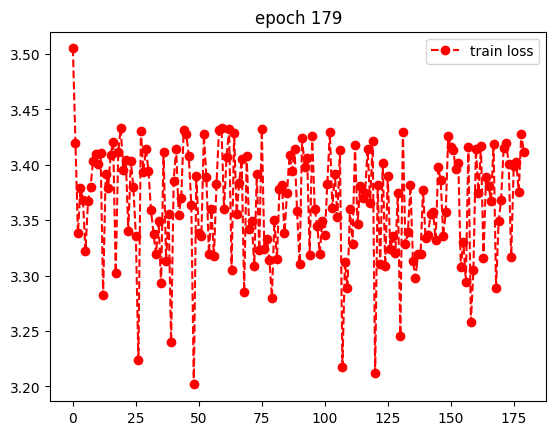

Time		0.65 sec 

EPOCH  179 	LOSS  3.411226175612802
-----------------------------------------------
-----------------------------------------------
48
bestvaleur 3.2017294921982997
TEACHER FORCE RATIO	 0.0
shape of visual initial vsn : torch.Size([40, 8, 512])
torch.Size([40, 8, 256])
torch.Size([40, 8, 256])
torch.Size([40, 8, 256])
torch.Size([40, 12, 256])
torch.Size([40, 12, 4])
torch.Size([40, 12, 2])


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.25 GiB (GPU 0; 23.69 GiB total capacity; 5.71 GiB already allocated; 75.12 MiB free; 11.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [44]:
print("TRAIN")
model.train()
print("path mode\t",path_mode)
loss  = train(model, optimizer, scheduler, criterion, criterion_vision, clip, train_loader, validation_loader)
print("LOSS ",loss)

In [ ]:
def load_checkpoint(model, optimizer, scheduler, filename='checkpoint.pth.tar'):
    start_epoch = 0
    best_val=-1
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        try:
            best_val=checkpoint['best_loss']
        except:
            best_val=-1
        print("=> loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, scheduler, start_epoch, best_val

In [ ]:
print("LOAD MODEL")
# Change device to cpu
del model
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model      = Seq2Seq(in_size, embed_size, hidden_size, dropout_val=dropout_val, batch_size=batch_size)
model, optimizer, scheduler, start_epoch, best_val = load_checkpoint(model, optimizer, scheduler, filename='./save_models/model_best.pth')
model.cuda()

In [ ]:
#test dataset and loader
print("Initializing val dataset")
dataset_val   = TrajectoryPredictionDataset(image_folder_path, DB_PATH_val, cnx_val)
test_loader   = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=False, pin_memory=True)

In [ ]:
print("EVALUATE bst")

model.eval()
path_mode = 'bst'
print("path mode\t",path_mode)
evaluate_eval(model, optimizer, criterion, criterion_vision, clip, test_loader)

In [ ]:
print("EVALUATE top5")
model.eval()
path_mode = 'top5'
print("path mode\t",path_mode)
evaluate_eval(model, optimizer, criterion, criterion_vision, clip, test_loader)